# Honey bee subspecies classifier

Here I am developing a classifier for honey bee subspecies, based on the composition of their cuticular hydrocarbons.
The cuticular hydrocarbons are a complex mixture of hydrocarbons that coat the surface of insects' body.
Different honey bee subspecies have different cuticular hydrocarbon compositions, so they should be recognizable by their charactieriztic compostion.

This project aims o develop a ML classifier, testing different methods to classify honey bee by susbpecies, based on their cuticular hydrocarbon composition.
For this, I will used the data from a study on the composition of the cuticular hydrocarbons of six european honey bee subspecies.
The data is hosted on a persistent public Figshare repository (https://doi.org/10.6084/m9.figshare.26831008.v1).

## Set-up

First I will download the dataset from the public figshare repository.

In [58]:
# Import the requests library to handle HTTP requests
import requests

# Direct download URL from Figshare
url = 'https://figshare.com/ndownloader/files/48787249'

# Where the dataset ZIP file will be downloaded
output_path = 'data.zip'  

# Send an HTTP GET request to the Figshare download URL
response = requests.get(url)

# Raise an exception if the request failed (e.g., due to network issues or a bad URL)
response.raise_for_status()

# Open a local file in binary write mode and write the downloaded content to it
with open(output_path, 'wb') as f:
    f.write(response.content)

# Print a confirmation message showing where the file was saved
print(f'Dataset downloaded to {output_path}')

Dataset downloaded to data.zip


The ZIP files contains several files that allow reproducing the data analysis for the original study in R.

As I am not interested on doign this, I will only extract the data itself.

In [59]:
# Import zipfile module to work with ZIP archives
import zipfile
# Import os module
## will be used to ensure the destination folder exists and to 
## simplify internal folder paths from filenames in the ZIP file
## ensuring a simple data folder structure
import os

# Define the path to the ZIP file
zip_path = 'data.zip'

# Make a list of the files contained in the ZIP file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    file_list = zip_ref.namelist()

# Print list of file sin the ZIP file
print("Files in ZIP archive:")
for file in file_list:
    print(file)

Files in ZIP archive:
dsrodriguezl-CHC-variation-in-EU-honey-bee-subspecies-36242c3cb9f8237e0fbdbd98ec2df7d0d4dfe400/
dsrodriguezl-CHC-variation-in-EU-honey-bee-subspecies-36242c3cb9f8237e0fbdbd98ec2df7d0d4dfe400/.Rprofile
dsrodriguezl-CHC-variation-in-EU-honey-bee-subspecies-36242c3cb9f8237e0fbdbd98ec2df7d0d4dfe400/.gitignore
dsrodriguezl-CHC-variation-in-EU-honey-bee-subspecies-36242c3cb9f8237e0fbdbd98ec2df7d0d4dfe400/CHC-variation-in-EU-honey-bee-subspecies.Rproj
dsrodriguezl-CHC-variation-in-EU-honey-bee-subspecies-36242c3cb9f8237e0fbdbd98ec2df7d0d4dfe400/README.html
dsrodriguezl-CHC-variation-in-EU-honey-bee-subspecies-36242c3cb9f8237e0fbdbd98ec2df7d0d4dfe400/README.md
dsrodriguezl-CHC-variation-in-EU-honey-bee-subspecies-36242c3cb9f8237e0fbdbd98ec2df7d0d4dfe400/analysis.R
dsrodriguezl-CHC-variation-in-EU-honey-bee-subspecies-36242c3cb9f8237e0fbdbd98ec2df7d0d4dfe400/composition_data.csv
dsrodriguezl-CHC-variation-in-EU-honey-bee-subspecies-36242c3cb9f8237e0fbdbd98ec2df7d0d4dfe400/

I am interested in the composition_data.csv and samples_list.csv files.

These are the only CSV files in teh ZIP file.

In [60]:
# List the specific files to extract from the archive
# These must match the internal paths as listed by zip_ref.namelist()
# I am filtering file_list to include files that end with '.csv' in the target_files list
target_files = [file for file in file_list if file.endswith('.csv')]

# Define the destination folder where selected files will be extracted
extract_to = 'data'

# Ensure the destination folder exists (create it if missing)
os.makedirs(extract_to, exist_ok=True)

# Open the ZIP archive in read mode ('r')
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    # Loop through each file in the target list
    for file in target_files:
        # Check if the file exists in the archive
        if file in zip_ref.namelist():
            # Extract the file content and write it directly into the target folder
            # Use os.path.basename(file) to remove the internal folder structure and keep only the filename
            with zip_ref.open(file) as source, open(os.path.join(extract_to, os.path.basename(file)), 'wb') as target:
                target.write(source.read())
            print(f'Extracted: {file}')
        else:
            # Warn if the file was not found in the archive
            print(f'File not found in archive: {file}')

Extracted: dsrodriguezl-CHC-variation-in-EU-honey-bee-subspecies-36242c3cb9f8237e0fbdbd98ec2df7d0d4dfe400/composition_data.csv
Extracted: dsrodriguezl-CHC-variation-in-EU-honey-bee-subspecies-36242c3cb9f8237e0fbdbd98ec2df7d0d4dfe400/samples_list.csv


Now that the data is downloaded, let's load it as data frames.

In [61]:
# Import libraries for data manipulation
import numpy as np
import pandas as pd

# Load the extracted CSV files into pandas DataFrames
composition_data = pd.read_csv("data/composition_data.csv")
samples = pd.read_csv("data/samples_list.csv")

## Data exploration

Now that the data is loaded, it is necessary to understand its structure and state.

Form the description in the original study (https://doi.org/10.1186/s12862-024-02325-z), the composition data corresponds to the relative abundance (%) of compounds in the cuticular hydrocarbon profile of each bee.

In [62]:
# What are the dimmensions and content structure of the data frames?
print("Dimensions of composition data df: ", composition_data.shape)
composition_data.head()

Dimensions of composition data df:  (93, 124)


,Unnamed: 0,Class,Chain.length,RI,S_Nu_Me_136,S_Nu_Me_137,S_Nu_Me_138,S_Nu_Me_139,S_Nu_Me_140,S_Nu_Me_141,...,S_PF_Ca_370,S_PF_Ca_371,S_PF_Ca_372,S_PF_Ca_375,S_PF_Ca_376,S_PF_Ca_377,S_PF_Ca_379,S_PF_Ca_380,S_PF_Ca_381,S_PF_Ca_383
0,C17:2,Alkadiene,17,1659,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.00000,0.000000,0.0
1,8-C17:1,Alkene,17,1666,0.031041,0.000000,0.000000,0.090019,0.034149,0.017368,...,0.0,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.00000,0.000000,0.0
2,C17,Alkane,17,1700,0.030832,0.000000,0.019784,0.080876,0.021133,0.016432,...,0.0,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.00000,0.000000,0.0
3,C19:2,Alkadiene,19,1863,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.00000,0.000000,0.0
4,9-C19:1,Alkene,19,1875,0.702819,0.043745,0.057616,0.353750,0.291931,0.350043,...,0.0,0.096332,0.128872,0.148687,0.38716,0.0,0.0,0.69138,0.189409,0.0


The composition data frame consist of 124 columns and 93 rows, with the rows correspondggn to the compounds in the cuticular hydrocarbon porfiles of the bees
The first four columns have information on the compounds; compound name, compound class, compound chain length, and retention index.
The rest of the columns correspond to a bee sample, with each row containign the abundance (%) of each compound in the cuticular hydrocarbon profile of the bees.

In [63]:
print("Dimensions of samples df: ", samples.shape)
samples.head()

Dimensions of samples df:  (120, 4)


,Unnamed: 0,Task,Subspecies,Individual
0,S_Nu_Me_136,Nurses,A. m. mellifera,136
1,S_Nu_Me_137,Nurses,A. m. mellifera,137
2,S_Nu_Me_138,Nurses,A. m. mellifera,138
3,S_Nu_Me_139,Nurses,A. m. mellifera,139
4,S_Nu_Me_140,Nurses,A. m. mellifera,140


The samples data frame lists tha samples and contains information regarding them.
The data frame has 120 rows and four columns; the sample labels, task of the bee, subspecies of the bees, and the individual number of the bee.
The sample labels summarize the information in the other columns.

The data set contains 120 samples in total, considerign the number of rows in the samples data frame and the samples columns in the composition data frame.

In [64]:
# Are there missing values?
composition_data.isna().sum()

Unnamed: 0      0
Class           0
Chain.length    0
RI              0
S_Nu_Me_136     0
               ..
S_PF_Ca_377     0
S_PF_Ca_379     0
S_PF_Ca_380     0
S_PF_Ca_381     0
S_PF_Ca_383     0
Length: 124, dtype: int64

In [65]:
samples.isna().sum()

Unnamed: 0    0
Task          0
Subspecies    0
Individual    0
dtype: int64

There is no missing data in the data frames.

In [66]:
# What is the format / type of the data?
composition_data.dtypes

Unnamed: 0       object
Class            object
Chain.length      int64
RI                int64
S_Nu_Me_136     float64
                 ...   
S_PF_Ca_377     float64
S_PF_Ca_379     float64
S_PF_Ca_380     float64
S_PF_Ca_381     float64
S_PF_Ca_383     float64
Length: 124, dtype: object

The compound chain length and retention index are integers, the abundance of compounds in the cuticular hydrocabron profile sof the bees are floats.

In [67]:
samples.dtypes

Unnamed: 0    object
Task          object
Subspecies    object
Individual     int64
dtype: object

The individual numbers are integers.

In [68]:
# Is the data set balanced for the six different subspecies?
samples.groupby('Subspecies'). count()

,Unnamed: 0,Task,Individual
Subspecies,,,
A. m. carnica,20,20,20
A. m. iberiensis,20,20,20
A. m. ligustica,20,20,20
A. m. macedonica,20,20,20
A. m. mellifera,20,20,20
A. m. ruttneri,20,20,20


The data set is perfectly balanced across subspecies.

In [69]:
# What is the exact scale of the abundance data?
composition_data.drop(columns=['Unnamed: 0', 'Class', 'Chain.length', 'RI']).sum().unique()

array([100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100.])

The composition data is in the percentage scale for all bees, summing up to 100 in each sample.

## Data processing

These data frames are not in the most convenient format.

I will transform them to get a single data frame with the data I will use for the classifier.

In [70]:
# List obf compound names
compounds = composition_data.iloc[:, 0].tolist()
# Transform composition data frame
composition_data = (composition_data
    # Drop first four columns
    .drop(columns=['Unnamed: 0', 'Class', 'Chain.length', 'RI'])
    
    # Transpose, so samples are rows and compounds columns (variables)
    .T
)

# Make the compound names the column (variable) names 
composition_data.columns = compounds
composition_data.head()

,C17:2,8-C17:1,C17,C19:2,9-C19:1,C19,C20,C21:2,9-C21:1,C21,...,C33:2_3,10-C33:1,C33,17-; 15-; 13-MeC33,"13, 19-diMeC33",C35:2_1,C35:2_2,12-; 10-C35:1,C35,19-; 17-; 15-MeC37
S_Nu_Me_136,0.0,0.031041,0.030832,0.0,0.702819,0.187658,0.036155,0.0,0.075555,1.222726,...,0.0,5.731144,0.322205,0.162351,0.078282,0.188922,0.0,0.246038,0.0,0.0
S_Nu_Me_137,0.0,0.000000,0.000000,0.0,0.043745,0.168443,0.022561,0.0,0.029899,1.570432,...,0.0,8.708913,0.628939,1.868788,0.461657,0.531766,0.0,0.631453,0.0,0.0
S_Nu_Me_138,0.0,0.000000,0.019784,0.0,0.057616,0.503714,0.038984,0.0,0.032695,1.276280,...,0.0,4.523627,1.982447,0.218301,0.228093,0.608159,0.0,0.649895,0.0,0.0
S_Nu_Me_139,0.0,0.090019,0.080876,0.0,0.353750,0.656529,0.044628,0.0,0.085152,2.056214,...,0.0,10.278659,1.504507,0.644647,0.435532,0.649382,0.0,0.667158,0.0,0.0
S_Nu_Me_140,0.0,0.034149,0.021133,0.0,0.291931,0.230487,0.041427,0.0,0.050477,1.324129,...,0.0,7.390895,1.004196,0.565886,0.293464,0.507709,0.0,0.518430,0.0,0.0


In [71]:
samples.iloc[:, 0].to_list() == composition_data.index.to_list()

True

The order of the samples in both data frames is the same, so they can be easily merged by binding their columns.

In [72]:
# Combine samples and composition_data side by side (column-wise)
merged_df = pd.concat([samples.set_index(samples.columns[0]) # change index to match those of composition_data
                       , composition_data], axis=1)
merged_df.head()

,Task,Subspecies,Individual,C17:2,8-C17:1,C17,C19:2,9-C19:1,C19,C20,...,C33:2_3,10-C33:1,C33,17-; 15-; 13-MeC33,"13, 19-diMeC33",C35:2_1,C35:2_2,12-; 10-C35:1,C35,19-; 17-; 15-MeC37
S_Nu_Me_136,Nurses,A. m. mellifera,136,0.0,0.031041,0.030832,0.0,0.702819,0.187658,0.036155,...,0.0,5.731144,0.322205,0.162351,0.078282,0.188922,0.0,0.246038,0.0,0.0
S_Nu_Me_137,Nurses,A. m. mellifera,137,0.0,0.000000,0.000000,0.0,0.043745,0.168443,0.022561,...,0.0,8.708913,0.628939,1.868788,0.461657,0.531766,0.0,0.631453,0.0,0.0
S_Nu_Me_138,Nurses,A. m. mellifera,138,0.0,0.000000,0.019784,0.0,0.057616,0.503714,0.038984,...,0.0,4.523627,1.982447,0.218301,0.228093,0.608159,0.0,0.649895,0.0,0.0
S_Nu_Me_139,Nurses,A. m. mellifera,139,0.0,0.090019,0.080876,0.0,0.353750,0.656529,0.044628,...,0.0,10.278659,1.504507,0.644647,0.435532,0.649382,0.0,0.667158,0.0,0.0
S_Nu_Me_140,Nurses,A. m. mellifera,140,0.0,0.034149,0.021133,0.0,0.291931,0.230487,0.041427,...,0.0,7.390895,1.004196,0.565886,0.293464,0.507709,0.0,0.518430,0.0,0.0


The individual code might not be really useful since the data frame indexes correspond to the sample label.

In [73]:
merged_df = merged_df.drop(columns='Individual')

# Get the column names
cols = merged_df.columns.tolist()

merged_df.head()

,Task,Subspecies,C17:2,8-C17:1,C17,C19:2,9-C19:1,C19,C20,C21:2,...,C33:2_3,10-C33:1,C33,17-; 15-; 13-MeC33,"13, 19-diMeC33",C35:2_1,C35:2_2,12-; 10-C35:1,C35,19-; 17-; 15-MeC37
S_Nu_Me_136,Nurses,A. m. mellifera,0.0,0.031041,0.030832,0.0,0.702819,0.187658,0.036155,0.0,...,0.0,5.731144,0.322205,0.162351,0.078282,0.188922,0.0,0.246038,0.0,0.0
S_Nu_Me_137,Nurses,A. m. mellifera,0.0,0.000000,0.000000,0.0,0.043745,0.168443,0.022561,0.0,...,0.0,8.708913,0.628939,1.868788,0.461657,0.531766,0.0,0.631453,0.0,0.0
S_Nu_Me_138,Nurses,A. m. mellifera,0.0,0.000000,0.019784,0.0,0.057616,0.503714,0.038984,0.0,...,0.0,4.523627,1.982447,0.218301,0.228093,0.608159,0.0,0.649895,0.0,0.0
S_Nu_Me_139,Nurses,A. m. mellifera,0.0,0.090019,0.080876,0.0,0.353750,0.656529,0.044628,0.0,...,0.0,10.278659,1.504507,0.644647,0.435532,0.649382,0.0,0.667158,0.0,0.0
S_Nu_Me_140,Nurses,A. m. mellifera,0.0,0.034149,0.021133,0.0,0.291931,0.230487,0.041427,0.0,...,0.0,7.390895,1.004196,0.565886,0.293464,0.507709,0.0,0.518430,0.0,0.0


I will encode the categorical variables, including the subspecies.

In [74]:
from sklearn.preprocessing import LabelEncoder

# Initialize a dictionary to store mappings for each categorical column
label_maps = {}

# Loop through each column in the DataFrame
for col in merged_df.select_dtypes(include='object').columns:
    # Initialize label encoder
    le = LabelEncoder()
    
    # Fit and transform the column
    merged_df[col] = le.fit_transform(merged_df[col])
    
    # Store mapping dictionary: original label → encoded value
    label_maps[col] = dict(zip(le.classes_, le.transform(le.classes_)))

label_maps

{'Task': {'Foragers': np.int64(0), 'Nurses': np.int64(1)},
 'Subspecies': {'A. m. carnica': np.int64(0),
  'A. m. iberiensis': np.int64(1),
  'A. m. ligustica': np.int64(2),
  'A. m. macedonica': np.int64(3),
  'A. m. mellifera': np.int64(4),
  'A. m. ruttneri': np.int64(5)}}

In [75]:
merged_df.head()

,Task,Subspecies,C17:2,8-C17:1,C17,C19:2,9-C19:1,C19,C20,C21:2,...,C33:2_3,10-C33:1,C33,17-; 15-; 13-MeC33,"13, 19-diMeC33",C35:2_1,C35:2_2,12-; 10-C35:1,C35,19-; 17-; 15-MeC37
S_Nu_Me_136,1,4,0.0,0.031041,0.030832,0.0,0.702819,0.187658,0.036155,0.0,...,0.0,5.731144,0.322205,0.162351,0.078282,0.188922,0.0,0.246038,0.0,0.0
S_Nu_Me_137,1,4,0.0,0.000000,0.000000,0.0,0.043745,0.168443,0.022561,0.0,...,0.0,8.708913,0.628939,1.868788,0.461657,0.531766,0.0,0.631453,0.0,0.0
S_Nu_Me_138,1,4,0.0,0.000000,0.019784,0.0,0.057616,0.503714,0.038984,0.0,...,0.0,4.523627,1.982447,0.218301,0.228093,0.608159,0.0,0.649895,0.0,0.0
S_Nu_Me_139,1,4,0.0,0.090019,0.080876,0.0,0.353750,0.656529,0.044628,0.0,...,0.0,10.278659,1.504507,0.644647,0.435532,0.649382,0.0,0.667158,0.0,0.0
S_Nu_Me_140,1,4,0.0,0.034149,0.021133,0.0,0.291931,0.230487,0.041427,0.0,...,0.0,7.390895,1.004196,0.565886,0.293464,0.507709,0.0,0.518430,0.0,0.0


## Feature selection

Some of the compounds might be redundant with each other or with the task.

I will apply feature selection with K-best to find the best for the classification.

In [76]:
# Separate features and target
y = merged_df['Subspecies']
X = merged_df.drop(columns='Subspecies')

Firs I will visualize the scores for all the features, to decide on how to filter them.

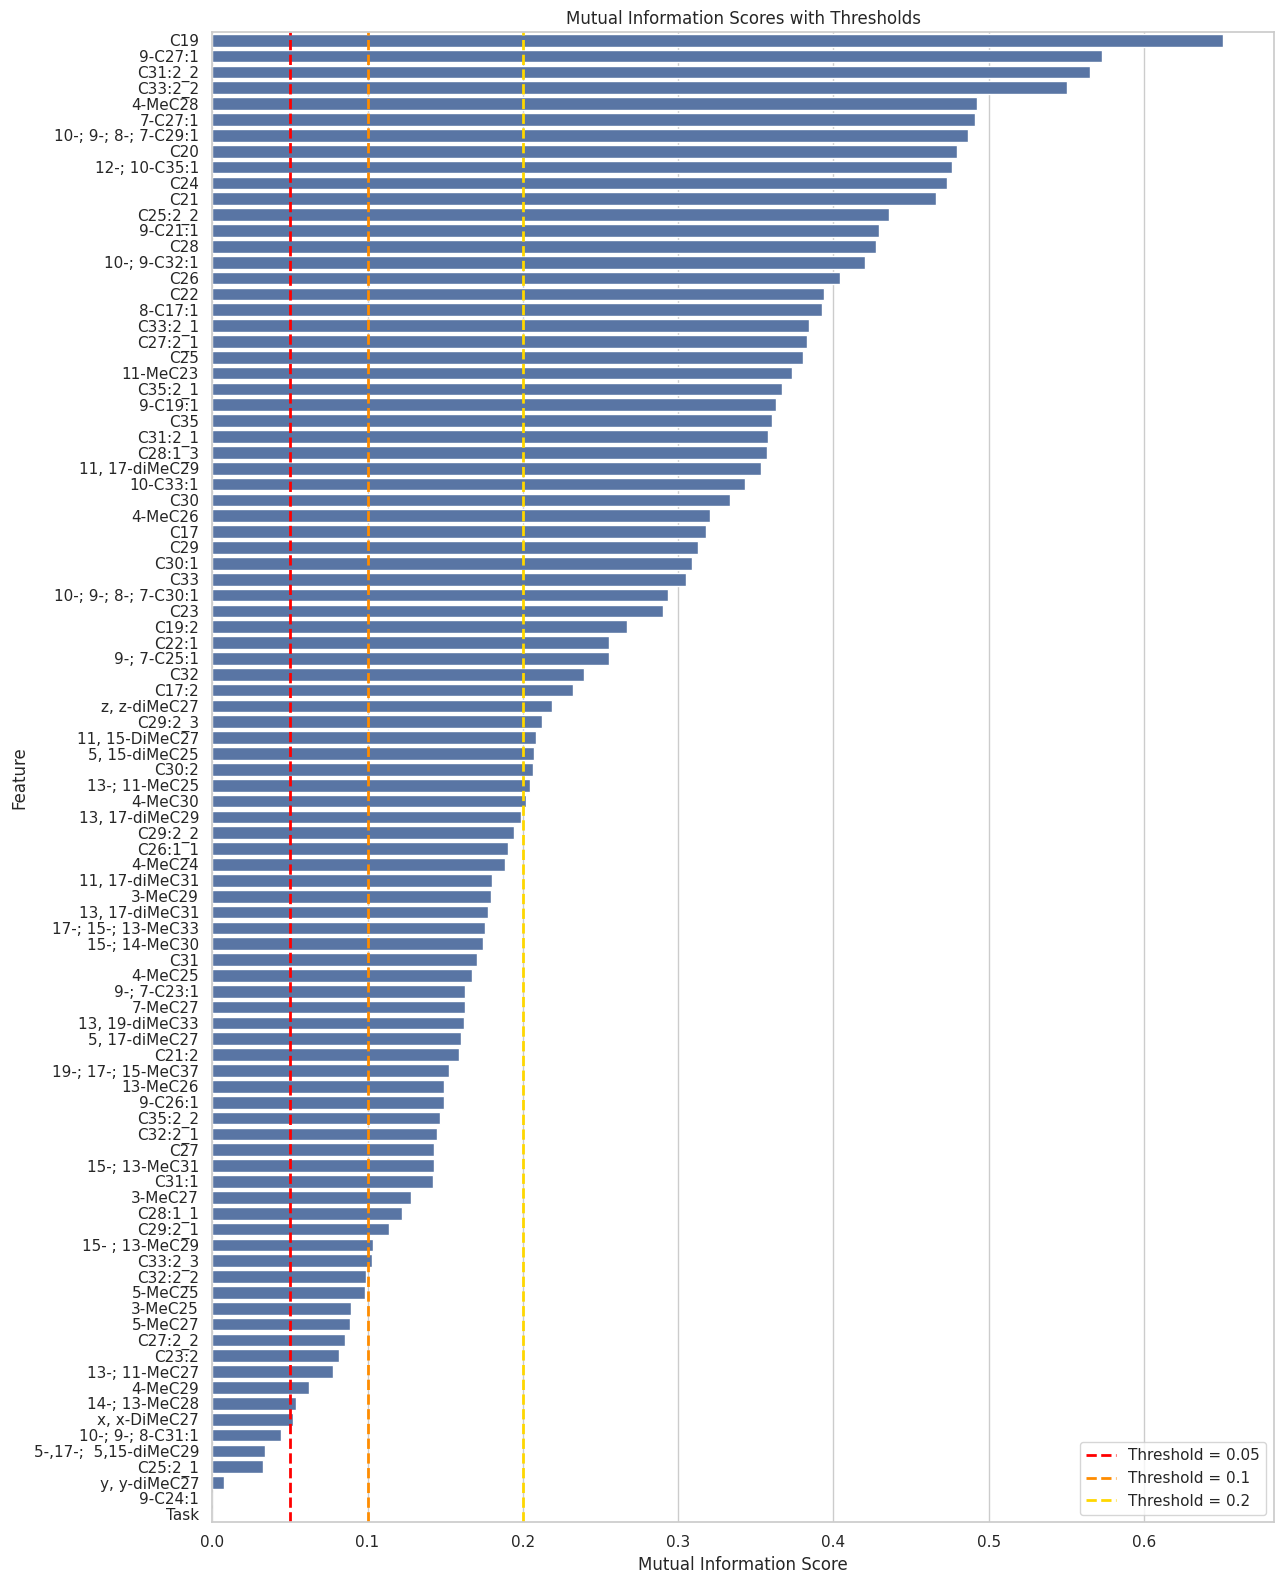

In [77]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest, mutual_info_classif

# Compute mutual information scores
selector = SelectKBest(score_func=lambda X, y: mutual_info_classif(X, y, random_state=42), k='all')
selector.fit(X, y)
scores = selector.scores_

# Create a DataFrame for scores
score_df = pd.DataFrame({
    'Feature': X.columns,
    'Score': scores
}).sort_values(by='Score', ascending=False)

# Plot
plt.figure(figsize=(13, 16))
sns.barplot(x='Score', y='Feature', data=score_df)

# Add threshold lines
## As the mutual information score ranges from 0 to 1, I will visualize three score thresholds
## They might be good cut-off limits fro filtering the features
plt.axvline(x=0.05, lw=2, color='red', linestyle='--', label='Threshold = 0.05')
plt.axvline(x=0.1, lw=2, color='darkorange', linestyle='--', label='Threshold = 0.1')
plt.axvline(x=0.2, lw=2, color='gold', linestyle='--', label='Threshold = 0.2')

# Labels and legend
plt.xlabel('Mutual Information Score')
plt.ylabel('Feature')
plt.title('Mutual Information Scores with Thresholds')
plt.legend()
plt.tight_layout()
plt.show()

In [78]:
# How many features pass the three different thresholds?
thresholds = [0.05, 0.1, 0.2]
for t in thresholds:
    count = (score_df['Score'] > t).sum()
    print(f"Features with score > {t}: {count}")

Features with score > 0.05: 88
Features with score > 0.1: 78
Features with score > 0.2: 49


The 0.05 threshold barely filters the least useful features, while the 0.2 thresholds seems a bit too extreme. It filters out almsot half of the features.
I will decide to use the 0.1 threshold.

In [79]:
# Select features base on the 0.1 threshold for their score
selected_features = score_df[score_df['Score'] > 0.1]['Feature'].tolist()
X_filtered = X[selected_features]
X_filtered.head()

,C19,9-C27:1,C31:2_2,C33:2_2,4-MeC28,7-C27:1,10-; 9-; 8-; 7-C29:1,C20,12-; 10-C35:1,C24,...,C35:2_2,C32:2_1,C27,15-; 13-MeC31,C31:1,3-MeC27,C28:1_1,C29:2_1,15- ; 13-MeC29,C33:2_3
S_Nu_Me_136,0.187658,2.579453,0.543545,0.0,0.0,2.305642,5.544805,0.036155,0.246038,0.591263,...,0.0,0.0,18.926694,0.260699,0.0,0.0,0.112418,0.055632,0.455483,0.0
S_Nu_Me_137,0.168443,0.795973,0.515753,0.0,0.0,0.281925,2.482879,0.022561,0.631453,0.358126,...,0.0,0.0,21.859296,3.914094,0.0,0.0,0.293957,0.000000,0.000000,0.0
S_Nu_Me_138,0.503714,2.049165,0.200988,0.0,0.0,1.372227,2.126388,0.038984,0.649895,0.566510,...,0.0,0.0,16.665720,0.392609,0.0,0.0,0.114489,0.045124,0.305742,0.0
S_Nu_Me_139,0.656529,0.801882,0.896712,0.0,0.0,0.464419,5.153208,0.044628,0.667158,0.411644,...,0.0,0.0,13.066103,0.740575,0.0,0.0,0.070236,0.038744,0.541498,0.0
S_Nu_Me_140,0.230487,2.288087,0.531827,0.0,0.0,2.132372,4.222772,0.041427,0.518430,0.535249,...,0.0,0.0,21.573758,0.315205,0.0,0.0,0.091627,0.071136,0.412320,0.0


## Train the classifiers

I will compare three different classification methods; SVM, Random Forest, and a custom MLP classifier.

First I will split the data into train and test sets.

In [80]:
from sklearn.model_selection import train_test_split

# Split data
## The split is stratified to preserve the data structure
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y, test_size=0.25, random_state=42, stratify=y)

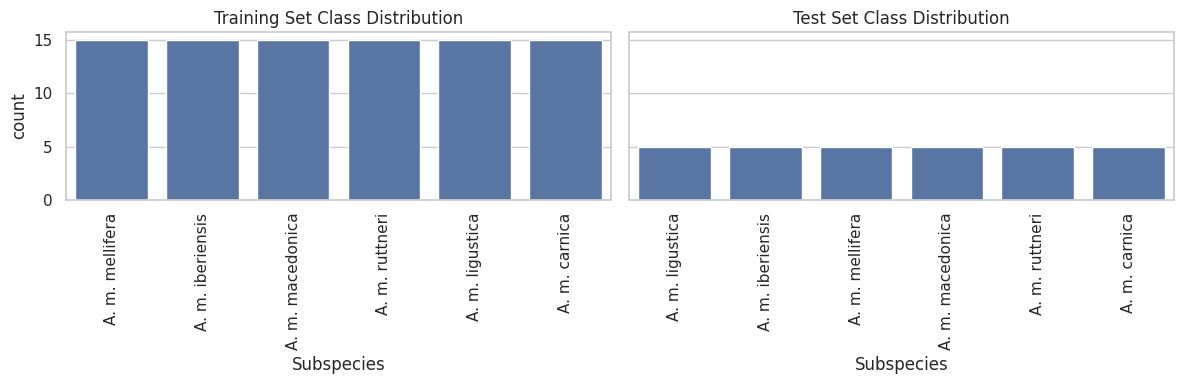

In [81]:
# Visualizing class distributions in both the train and test set

# Reverse the label map
reverse_map = {v: k for k, v in label_maps["Subspecies"].items()}

# Plot directly with mapped labels
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

sns.countplot(x=y_train.map(reverse_map), ax=axes[0])
axes[0].set_title('Training Set Class Distribution')
axes[0].set_xlabel('Subspecies')
axes[0].tick_params(axis='x', rotation=90)

sns.countplot(x=y_test.map(reverse_map), ax=axes[1])
axes[1].set_title('Test Set Class Distribution')
axes[1].set_xlabel('Subspecies')
axes[1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

The class distribution (balanced sampling structure) is preserved in both data splits.
Now we are ready to train and evaluate the classifiers.

For the three of them, I will perform a stratified K-fold cross valdation paired with hyperparameter tunning, via grid search.

### SVM Classifier

In [82]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# Define stratified K-Fold cross-validation to preserve class proportions across folds
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define hyperparameter grid for SVM
param_grid = {
    'C': [0.1, 0.25, 0.5, 1, 2.5, 5], # Regularization strength
    'kernel': ['linear', 'rbf'], # Type of decision boundary
    'gamma': ['scale', 'auto'] # Kernel coefficient for RBF kernel
}

# Initialize GridSearchCV
grid_svm = GridSearchCV(
    estimator=SVC(),
    param_grid=param_grid,
    # Compoute F1 and accuracy scores
    scoring={'f1_macro': 'f1_macro', 'accuracy': 'accuracy'},
    # Select best model based on F1 score
    refit='f1_macro',
    cv=cv,
    n_jobs=-1
)

# Fit the model on the training data using cross-validated hyperparameter tuning
grid_svm.fit(X_train, y_train)

# Retrieve the best-performing model based on cross-validated F1 score
final_svm = grid_svm.best_estimator_

# Predict on the held-out test set
y_pred = final_svm.predict(X_test)

# Evaluate performance using accuracy, macro-averaged F1 score, and confusion matrix
## Since the data set is perfectly balanced across classes, the macro-averaged F1 score seems adequate
svm_acc = accuracy_score(y_test, y_pred)
svm_f1 = f1_score(y_test, y_pred, average='macro')
svm_cm = confusion_matrix(y_test, y_pred)

# Display results
print("SVM Evaluation Results")
print(f"Best Parameters: {grid_svm.best_params_}")
print(f"Accuracy: {svm_acc:.4f}")
print(f"F1 Score (macro): {svm_f1:.4f}")
print("Confusion Matrix:\n", svm_cm)

SVM Evaluation Results
Best Parameters: {'C': 0.25, 'gamma': 'scale', 'kernel': 'linear'}
Accuracy: 0.9000
F1 Score (macro): 0.8944
Confusion Matrix:
 [[4 1 0 0 0 0]
 [0 5 0 0 0 0]
 [0 0 5 0 0 0]
 [0 0 0 5 0 0]
 [0 0 0 0 5 0]
 [0 0 1 1 0 3]]


It will better visualize the confussion matrix, and the other metrics, later when comparing the different classifiers.
For now, it seems the SVM is doing a good job for the classification.

### Random Forest Classifier

In [83]:
from sklearn.ensemble import RandomForestClassifier

# Define stratified K-Fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define hyperparameter grid for Random Forest
param_grid = {
    'n_estimators': [100, 200, 300, 400], # Number of trees in the forest
    'max_depth': [5, 10, 20, 50], # Maximum depth of each tree
    'min_samples_split': [2, 3, 5], # Minimum samples required to split an internal node
    'min_samples_leaf': [1, 2, 3] # Minimum samples required to be at a leaf node
}

# Initialize GridSearchCV
grid_rf = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    # Compoute F1 and accuracy scores
    scoring={'f1_macro': 'f1_macro', 'accuracy': 'accuracy'},
    # Select best model based on F1 score
    refit='f1_macro',
    cv=cv,
    n_jobs=-1
)

# Fit the model on the training data using cross-validated hyperparameter tuning
grid_rf.fit(X_train, y_train)

# Retrieve the best-performing model based on cross-validated F1 score
final_rf = grid_rf.best_estimator_

# Final training on the full training set with the best hyperparameters
#final_rf = RandomForestClassifier(**grid_rf.best_params_, random_state=42)
#final_rf.fit(X_train, y_train)

# Predict on the held-out test set
y_pred = final_rf.predict(X_test)

# Evaluate performance using accuracy, macro-averaged F1 score, and confusion matrix
rf_acc = accuracy_score(y_test, y_pred)
rf_f1 = f1_score(y_test, y_pred, average='macro')
rf_cm = confusion_matrix(y_test, y_pred)

# Display results
print("Random Forest Evaluation Results")
print(f"Best Parameters: {grid_rf.best_params_}")
print(f"Accuracy: {rf_acc:.4f}")
print(f"F1 Score (macro): {rf_f1:.4f}")
print("Confusion Matrix:\n", rf_cm)

Random Forest Evaluation Results
Best Parameters: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Accuracy: 1.0000
F1 Score (macro): 1.0000
Confusion Matrix:
 [[5 0 0 0 0 0]
 [0 5 0 0 0 0]
 [0 0 5 0 0 0]
 [0 0 0 5 0 0]
 [0 0 0 0 5 0]
 [0 0 0 0 0 5]]


### MLP Classifier (with pytorch)

In [84]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, Subset
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
import copy
import random
from itertools import product

# Reproducibility setup
def set_seed(seed=42):
    # Set random seeds for reproducibility across numpy, random, and PyTorch.
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(seed=42)

# Select device: use GPU if available, otherwise fallback to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


#### Data Preparation

In [85]:
# Convert input data to NumPy arrays
X_train_np = np.asarray(X_train, dtype=np.float32)
X_test_np = np.asarray(X_test, dtype=np.float32)
y_train_np = np.asarray(y_train, dtype=int)
y_test_np = np.asarray(y_test, dtype=int)

# Wrap training data in a TensorDataset
train_dataset = TensorDataset(torch.from_numpy(X_train_np), torch.from_numpy(y_train_np))
n_classes = len(np.unique(y_train_np))
input_dim = X_train_np.shape[1]

#### Training and Evaluation Utilities

In [86]:
# Train the model for one full epoch using the provided DataLoader.
# Returns average training loss over the epoch.
def train_epoch(model, loader, criterion, optimizer):
    model.train()  # Enable training mode
    total_loss = 0.0

    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device).long()
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)

    return total_loss / len(loader.dataset)


## Evaluate the model on a validation or test DataLoader.
## Returns average loss, predicted labels, and true labels.
def evaluate(model, loader, criterion):
    model.eval()
    total_loss = 0.0
    preds, trues = [], []

    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device).long()
            logits = model(xb)
            loss = criterion(logits, yb)
            total_loss += loss.item() * xb.size(0)
            preds.append(torch.argmax(logits, dim=1).cpu().numpy())
            trues.append(yb.cpu().numpy())

    return total_loss / len(loader.dataset), np.concatenate(preds), np.concatenate(trues)

#### MLP architecture definition

In [87]:
# Defines a deep MLP with 5 hidden layers, ReLU activations, and residual connections.
class DeepMLP(nn.Module):
    # Hidden layer widths decrease progressively from 256 to 64, for gradual compression and abstraction.
    # Residual connections are added every 2 layers. Projection layers align dimensions when needed.
    def __init__(self, input_dim, n_classes):
        super().__init__()

        # Fixed hidden layer sizes for gradual compression
        self.hidden_sizes = [256, 192, 128, 96, 64]

        # Create linear layers and activations explicitly
        self.linears = nn.ModuleList()
        self.activations = nn.ModuleList()

        for i, h in enumerate(self.hidden_sizes):
            in_dim = input_dim if i == 0 else self.hidden_sizes[i - 1]

            self.linears.append(nn.Linear(in_dim, h))     # Linear transformation
            self.activations.append(nn.ReLU())            # Nonlinearity

        # Final output layer: maps last hidden size to number of classes
        self.output_layer = nn.Linear(self.hidden_sizes[-1], n_classes)

        # Projection layers for residual compatibility
        self.projections = nn.ModuleDict()

        for i in range(1, len(self.hidden_sizes)):
            prev = self.hidden_sizes[i - 1]
            curr = self.hidden_sizes[i]

            # Residuals added every 2 layers (i = 1, 3)
            if i % 2 == 1 and prev != curr:
                self.projections[f"{i}"] = nn.Linear(prev, curr)

    # Forward pass with residual connections every 2 layers
    def forward(self, x):
        out = x  # Initial input

        for i in range(len(self.hidden_sizes)):
            residual = out  # Save input for residual
            out = self.linears[i](out)
            out = self.activations[i](out)

            # Apply residual every 2 layers (i = 1, 3)
            if i % 2 == 1:
                if f"{i}" in self.projections:
                    residual = self.projections[f"{i}"](residual)
                out = out + residual

        return self.output_layer(out)  # Final logits

#### Hyperparameter grid

In [88]:
## Define grid for learning rate, weight decay, and early stopping patience.
LEARNING_RATES = [1e-2, 1e-3, 1e-4]
WEIGHT_DECAYS = [0, 1e-4, 1e-3]
PATIENCES = [5, 10, 20]

best_config = None
best_cv_f1 = -np.inf

#### Grid search with 5-fold cross-validation

In [89]:
for lr, wd, pt in product(LEARNING_RATES, WEIGHT_DECAYS, PATIENCES):
    print(f"\n=== Grid Search | lr={lr} | wd={wd} | patience={pt} ===")
    fold_f1s = []
    fold_accs = []
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    for fold_idx, (train_idx, val_idx) in enumerate(cv.split(X_train_np, y_train_np)):
        set_seed(42)

        # Full-batch loaders for reproducibility
        train_loader = DataLoader(Subset(train_dataset, train_idx), batch_size=len(train_idx), shuffle=False)
        val_loader = DataLoader(Subset(train_dataset, val_idx), batch_size=len(val_idx), shuffle=False)

        # Model, loss, optimizer
        model = DeepMLP(input_dim, n_classes).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

        best_val_f1 = -np.inf
        best_state = None
        patience = pt

        # Training loop with early stopping
        for epoch in range(100):
            train_loss = train_epoch(model, train_loader, criterion, optimizer)
            _, val_preds, val_trues = evaluate(model, val_loader, criterion)
            val_f1 = f1_score(val_trues, val_preds, average='macro')

            print(f"Fold {fold_idx+1} | Epoch {epoch+1:03d} | Train Loss: {train_loss:.4f} | Val F1: {val_f1:.4f} | Best F1: {best_val_f1:.4f} | Patience: {patience}")

            if val_f1 > best_val_f1 + 1e-6:
                best_val_f1 = val_f1
                val_acc = accuracy_score(val_trues, val_preds)
                best_state = copy.deepcopy(model.state_dict())
                patience = pt

            else:
                patience -= 1
            if patience == 0:
                break

        fold_f1s.append(best_val_f1)
        fold_accs.append(val_acc)

    avg_f1 = np.mean(fold_f1s)
    print(f"Average CV F1: {avg_f1:.4f}")

    if avg_f1 > best_cv_f1:
        best_cv_f1 = avg_f1
        best_config = {
            "learning_rate": lr,
            "weight_decay": wd,
            "patience": pt
        }

print("\nBest Hyperparameters: ")
for k, v in best_config.items():
    print(f"{k}: {v}")
print(f"Best CV F1: {best_cv_f1:.4f}")


=== Grid Search | lr=0.01 | wd=0 | patience=5 ===
Fold 1 | Epoch 001 | Train Loss: 1.7989 | Val F1: 0.0476 | Best F1: -inf | Patience: 5
Fold 1 | Epoch 002 | Train Loss: 1.9554 | Val F1: 0.1977 | Best F1: 0.0476 | Patience: 5
Fold 1 | Epoch 003 | Train Loss: 2.0327 | Val F1: 0.1833 | Best F1: 0.1977 | Patience: 5
Fold 1 | Epoch 004 | Train Loss: 1.6386 | Val F1: 0.1667 | Best F1: 0.1977 | Patience: 4
Fold 1 | Epoch 005 | Train Loss: 1.7090 | Val F1: 0.2182 | Best F1: 0.1977 | Patience: 3
Fold 1 | Epoch 006 | Train Loss: 1.8692 | Val F1: 0.4106 | Best F1: 0.2182 | Patience: 5
Fold 1 | Epoch 007 | Train Loss: 1.3596 | Val F1: 0.2963 | Best F1: 0.4106 | Patience: 5
Fold 1 | Epoch 008 | Train Loss: 1.2697 | Val F1: 0.3651 | Best F1: 0.4106 | Patience: 4
Fold 1 | Epoch 009 | Train Loss: 1.0618 | Val F1: 0.4008 | Best F1: 0.4106 | Patience: 3
Fold 1 | Epoch 010 | Train Loss: 1.0313 | Val F1: 0.3841 | Best F1: 0.4106 | Patience: 2
Fold 1 | Epoch 011 | Train Loss: 0.8045 | Val F1: 0.4008 | Be

#### Final Training with best parameters

In [90]:
set_seed(42)

val_split = 0.1
n_val = int(len(train_dataset) * val_split)
indices = np.arange(len(train_dataset))
np.random.shuffle(indices)
val_indices = indices[:n_val]
train_indices = indices[n_val:]

train_loader = DataLoader(Subset(train_dataset, train_indices), batch_size=len(train_indices), shuffle=False)
val_loader = DataLoader(Subset(train_dataset, val_indices), batch_size=len(val_indices), shuffle=False)

# Instantiate model with best hyperparameters
model = DeepMLP(input_dim, n_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),
                       lr=best_config["learning_rate"],
                       weight_decay=best_config["weight_decay"])

best_val_f1 = -np.inf
best_state = None
patience = best_config["patience"]


for epoch in range(100):
    train_loss = train_epoch(model, train_loader, criterion, optimizer)
    _, val_preds, val_trues = evaluate(model, val_loader, criterion)
    val_f1 = f1_score(val_trues, val_preds, average='macro')

    print(f"Final Train | Epoch {epoch+1:03d} | Train Loss: {train_loss:.4f} | Val F1: {val_f1:.4f} | Best F1: {best_val_f1:.4f} | Patience: {patience}")

    if val_f1 > best_val_f1 + 1e-6:
        best_val_f1 = val_f1
        best_state = copy.deepcopy(model.state_dict())
        patience = best_config["patience"]
    else:
        patience -= 1
    if patience == 0:
        break

Final Train | Epoch 001 | Train Loss: 1.7945 | Val F1: 0.0400 | Best F1: -inf | Patience: 20
Final Train | Epoch 002 | Train Loss: 1.9978 | Val F1: 0.1905 | Best F1: 0.0400 | Patience: 20
Final Train | Epoch 003 | Train Loss: 1.9600 | Val F1: 0.2167 | Best F1: 0.1905 | Patience: 20
Final Train | Epoch 004 | Train Loss: 1.5613 | Val F1: 0.2000 | Best F1: 0.2167 | Patience: 20
Final Train | Epoch 005 | Train Loss: 1.3900 | Val F1: 0.1444 | Best F1: 0.2167 | Patience: 19
Final Train | Epoch 006 | Train Loss: 2.2928 | Val F1: 0.1667 | Best F1: 0.2167 | Patience: 18
Final Train | Epoch 007 | Train Loss: 1.7305 | Val F1: 0.1500 | Best F1: 0.2167 | Patience: 17
Final Train | Epoch 008 | Train Loss: 1.5168 | Val F1: 0.4000 | Best F1: 0.2167 | Patience: 16
Final Train | Epoch 009 | Train Loss: 1.3652 | Val F1: 0.1667 | Best F1: 0.4000 | Patience: 20
Final Train | Epoch 010 | Train Loss: 1.2496 | Val F1: 0.1667 | Best F1: 0.4000 | Patience: 19
Final Train | Epoch 011 | Train Loss: 1.1856 | Val F

#### Final Evaluation on Test Set

In [91]:
model.load_state_dict(best_state)

test_loader = DataLoader(
    TensorDataset(torch.from_numpy(X_test_np), torch.from_numpy(y_test_np)),
    batch_size=len(y_test_np),
    shuffle=False
)

# Evaluate on held-out test set
_, test_preds, test_trues = evaluate(model, test_loader, criterion)

# Compute final metrics on the test set
mlp_acc = accuracy_score(test_trues, test_preds)  # Overall accuracy
mlp_f1 = f1_score(test_trues, test_preds, average='macro')  # Macro-averaged F1 score
mlp_cm = confusion_matrix(test_trues, test_preds)  # Confusion matrix for class-wise breakdown

# Print evaluation results
print("MLP Evaluation Results")
# Print best hyperparameters
print("Best Hyperparameters: ")
print(best_config)
print(f"Accuracy: {mlp_acc:.4f}")  # Print accuracy with 4 decimal places
print(f"F1 Score (macro): {mlp_f1:.4f}")  # Print macro F1 score
print("Confusion Matrix:\n", mlp_cm)  # Display confusion matrix

MLP Evaluation Results
Best Hyperparameters: 
{'learning_rate': 0.01, 'weight_decay': 0.0001, 'patience': 20}
Accuracy: 0.8667
F1 Score (macro): 0.8598
Confusion Matrix:
 [[5 0 0 0 0 0]
 [0 5 0 0 0 0]
 [0 0 5 0 0 0]
 [0 0 0 3 1 1]
 [0 0 0 0 5 0]
 [0 0 2 0 0 3]]


## Comparative evaluation of the three classifiers

### Per-Fold Metric visualization

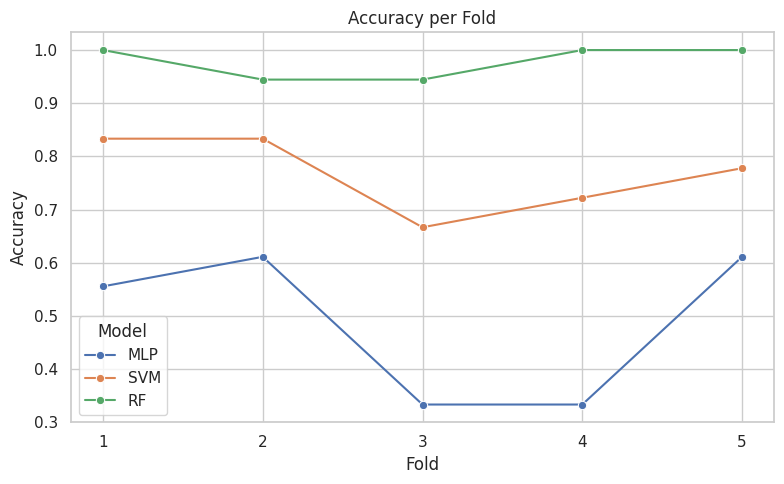

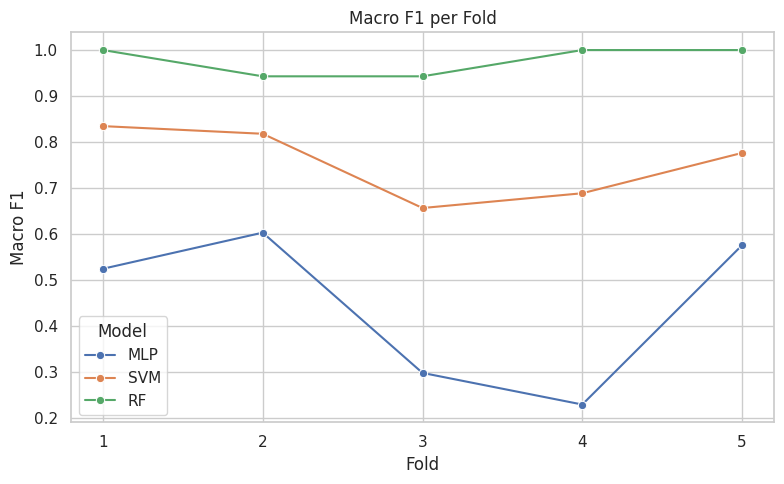

In [92]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Extract per-fold scores from GridSearchCV 
## Extracts fold-wise macro F1 scores from a GridSearchCV object
def extract_f1_scores(grid_object):
    best_idx = grid_object.best_index_
    return [
        grid_object.cv_results_[f'split{i}_test_f1_macro'][best_idx]
        for i in range(grid_object.n_splits_)
    ]

## Extracts fold-wise accuracy scores from a GridSearchCV object run with
def extract_accuracy_scores(grid_object):
    best_idx = grid_object.best_index_
    return [
        grid_object.cv_results_[f'split{i}_test_accuracy'][best_idx]
        for i in range(grid_object.n_splits_)
    ]

# Extract fold-wise macro F1 scores
mlp_f1_scores = fold_f1s
svm_f1_scores = extract_f1_scores(grid_svm)
rf_f1_scores  = extract_f1_scores(grid_rf)

# Extract fold-wise accuracy scores
mlp_acc_scores = fold_accs
svm_acc_scores = extract_accuracy_scores(grid_svm)
rf_acc_scores  = extract_accuracy_scores(grid_rf)

# Prepare DataFrames for plotting
folds = list(range(1, len(mlp_f1_scores) + 1))
df_acc = pd.DataFrame({
    'Fold': folds * 3,
    'Accuracy': mlp_acc_scores + svm_acc_scores + rf_acc_scores,
    'Model': ['MLP']*len(folds) + ['SVM']*len(folds) + ['RF']*len(folds)
})

df_f1 = pd.DataFrame({
    'Fold': folds * 3,
    'Macro F1': mlp_f1_scores + svm_f1_scores + rf_f1_scores,
    'Model': ['MLP']*len(folds) + ['SVM']*len(folds) + ['RF']*len(folds)
})

# Plot Accuracy per Fold 
sns.set(style="whitegrid")
plt.figure(figsize=(8, 5))
sns.lineplot(data=df_acc, x='Fold', y='Accuracy', hue='Model', marker='o')
plt.xticks(range(1, len(folds) + 1))   # force integer ticks
plt.title('Accuracy per Fold')
plt.tight_layout()
plt.show()

# Plot Macro F1 per Fold
plt.figure(figsize=(8, 5))
sns.lineplot(data=df_f1, x='Fold', y='Macro F1', hue='Model', marker='o')
plt.xticks(range(1, len(folds) + 1))   # force integer ticks
plt.title('Macro F1 per Fold')
plt.tight_layout()
plt.show()

### Visualization of performance on final evaluation

#### Accuracies and F1 scores

     Metric Model     Score
0  Accuracy   MLP  0.866667
1  Accuracy   SVM  0.900000
2  Accuracy    RF  1.000000
3  Macro F1   MLP  0.859848
4  Macro F1   SVM  0.894360
5  Macro F1    RF  1.000000


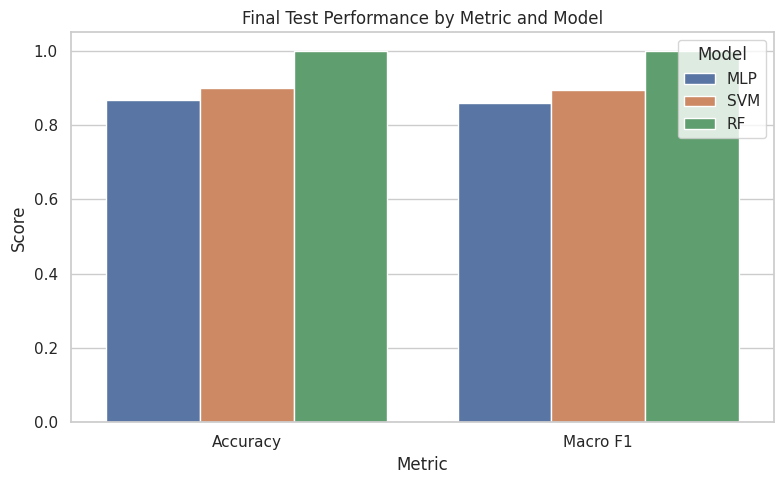

In [93]:
# Ensure scalar values
def ensure_scalar(x):
    return x[0] if isinstance(x, list) else x

# Ensure all test metrics are scalars
mlp_acc = ensure_scalar(mlp_acc)
svm_acc = ensure_scalar(svm_acc)
rf_acc  = ensure_scalar(rf_acc)

mlp_f1 = ensure_scalar(mlp_f1)
svm_f1 = ensure_scalar(svm_f1)
rf_f1  = ensure_scalar(rf_f1)

# Prepare combined DataFrame
df_combined = pd.DataFrame({
    'Metric': ['Accuracy'] * 3 + ['Macro F1'] * 3,
    'Model': ['MLP', 'SVM', 'RF'] * 2,
    'Score': [mlp_acc, svm_acc, rf_acc, mlp_f1, svm_f1, rf_f1]
})
print(df_combined)

# Plot grouped bar chart
sns.set(style="whitegrid")
plt.figure(figsize=(8, 5))
sns.barplot(data=df_combined, x='Metric', y='Score', hue='Model')
plt.title('Final Test Performance by Metric and Model')
plt.tight_layout()
plt.show()

#### Confusion matrices

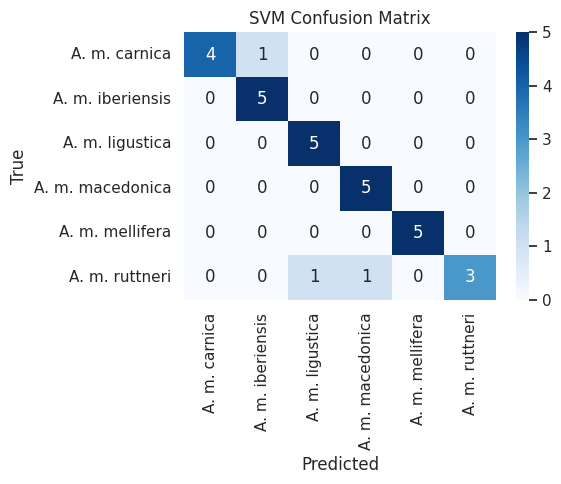

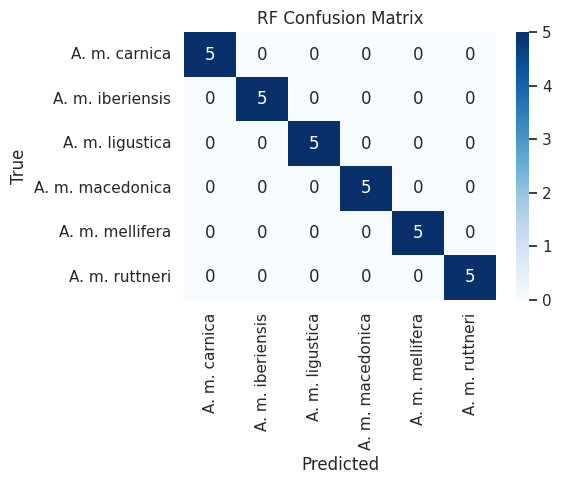

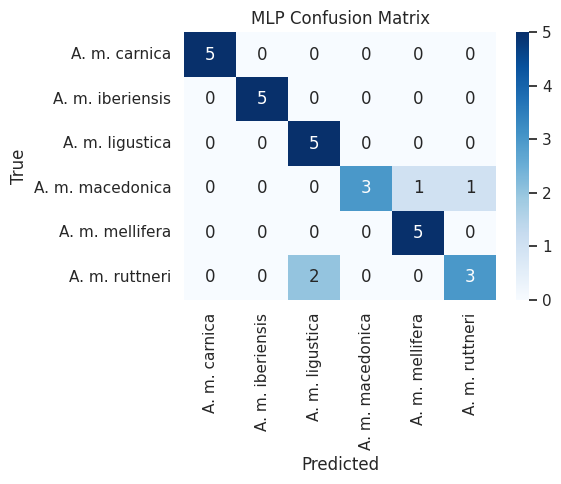

In [94]:
# Invert the label map for 'Subspecies' to get integer → label
inv_label_map = {v: k for k, v in label_maps['Subspecies'].items()}
class_names = [inv_label_map[i] for i in sorted(inv_label_map)]

# Confusion matrix plotting function
def plot_confusion_matrix(cm, model_name, class_labels):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_labels, yticklabels=class_labels)
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

# Plot confusion matrices for all models
plot_confusion_matrix(svm_cm, 'SVM', class_names)
plot_confusion_matrix(rf_cm,  'RF',  class_names)
plot_confusion_matrix(mlp_cm, 'MLP', class_names)